# Quick Navigation
* [1. Importing relevant libraries](#1)
* [2. Get the data](#2)
  * [2.1 Rename files in all folders](#3)
  * [2.2 Get all filenames from each folder](#4)
  * [2.3 Split data into train and test set](#5)
* [3. Prepare data for Training and Validation + Build CNN Model](#6)
  * [3.1 Prepare data](#7)
  * [3.2 Saving train and test data and labels](#8)
  * [3.3 Loading saved train and test data and labels](#9)
  * [3.4 Encoding labels using Label Binarizer](#10)
* [4. Experiment for Best CNN model architecture](#11)
  * [4.1 Notations used](#12)
  * [4.2 Choosing number of Conv-MaxPool pairs](#13)
  * [4.3 Choosing the right batch size and epochs](#14)
  * [4.4 Choosing right number of Feature Maps/ Filters](#15)
  * [4.5 Choosing right kernel size of feature maps/filters](#16)
  * [4.6 Choosing the right pool size](#17)
  * [4.7 Choosing Dense layer units](#18)
  * [4.8 Choosing right number of Dense layers](#19)
  * [4.9 Choosing activation](#20)
  * [4.10 Choosing Dropout](#21)
  * [4.11 Whether Batch Norm works for us or not ?](#22)
* [5. Final Model](#23)
* [6. Save Model and Label Binarizer](#24)
* [7. Classification on User data](#25)


<a id='1'></a>
# 1. Importing relevant dependencies

In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
from statistics import mean
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [ ]:
# Seed Everything !!
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

<a id='2'></a>
# 2. Get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='3'></a>
## 2.1 Rename files in all folders

***The idea here is to read the files, rename them and save them with new names. Default file name are just numbers. We will add label to them (eg:- red_dress_234, blue_jeans_23, etc.) so as to make it easier for us to fetch and input labels while training.***

In [ ]:
DIR = '/content/drive/My Drive/Fashion MNIST Project/dataset/'

# read folder names from directory
files = []
for files_ in os.listdir(DIR):
    files.append(files_)

In [ ]:
# read files within each folder and rename them inplace in same directory
# folder_num=0
# for foldername in files:
#     count=1
#     temp_dir = DIR + foldername + '/'
#     filenames = []
#     for fn_ in os.listdir(temp_dir):
#         os.rename(temp_dir + fn_, temp_dir + files[folder_num] + '_' + str(count) + '.jpg')
#         count+=1
#     folder_num+=1

<a id='4'></a>
## 2.2 Get all file names from each folder
Create a list of all files in dataset. This is done to get path to individual .jpg image. Later on, we will split this list, for training and testing purpose. 

In [ ]:
src_img_list = []
for folder in os.listdir(DIR):
  temp_dir = DIR + folder + '/'
  for imgs in os.listdir(temp_dir):
    src_img_list.append(temp_dir + imgs)

shuffle(src_img_list, random_state=42)

['/content/drive/My Drive/Fashion MNIST Project/dataset/black_jeans/black_jeans_144.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/blue_jeans/blue_jeans_253.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/red_dress/red_dress_369.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/black_shoes/black_shoes_156.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/blue_shirt/blue_shirt_265.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/black_jeans/black_jeans_290.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/blue_shirt/blue_shirt_107.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/blue_jeans/blue_jeans_265.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/black_jeans/black_jeans_265.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/blue_jeans/blue_jeans_52.jpg',
 '/content/drive/My Drive/Fashion MNIST Project/dataset/blue_dress/blue_dress_307.jpg',
 '/content/drive/My Drive/F

In [ ]:
print(f"There are {len(src_img_list)} image items in our dataset.")

There are 2690 image items in our dataset.


<a id='5'></a>
## 2.3 Split data into train and test set

- Train data : 80%
- Test data : 20%

In [ ]:
# train_len = int(len(src_img_list) * 0.8)
# train_data = src_img_list[0 : train_len]
# test_data = src_img_list[train_len : ]
train_data, test_data = train_test_split(src_img_list, test_size=0.2, random_state=42)

<a id='6'></a>
# 3. Prepare data for Training and Validation + Build CNN Model:

<a id='7'></a>
## 3.1 Preparing Data

In [ ]:
NUM_COLORS = 3
NUM_CATEGORIES = 4
IMG_DIMS = (96, 96, 3) #(h, w, c)

In [ ]:
def get_data_for_model(data):
  """
  Important : CV2 reads color in BGR order whereas tensorflow reads color in RGB order.
  It is important to convert color to RGB after reading each image.
  """
  X = []
  y_color = []
  y_category = []
  for path in tqdm(data):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_DIMS[1], IMG_DIMS[0])) # cv2.resize takes (width, height)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_category = path.split('/')[-1].split('_')
    (color, category) = color_category[0:2]
    
    # Normalize the image pixel values by bringing values in range 0 to 1
    img = img / 255.0

    X.append(img)
    y_color.append(color)
    y_category.append(category)
  
  return np.array(X) , np.array(y_color), np.array(y_category)

NOTE : Below 3 cells are commented. These are to be only run when running this file for the first time. 

These are commented because these cells are responsible for processing data and saving them and takes time everytime we run the file.

In [ ]:
# get train data and label for model training 
# X_train , y_color_train, y_category_train = get_data_for_model(train_data)

In [ ]:
# get test data and label for model testing 
# X_test, y_color_test, y_category_test = get_data_for_model(test_data)

<a id='8'></a>
## 3.2 Saving train and test data and labels for easy loading & to save time of processing images at runtime.

In [ ]:
# Save train data and target labels 
# np.save('/content/drive/My Drive/Fashion MNIST Project/train_data', X_train)
# np.save('/content/drive/My Drive/Fashion MNIST Project/train_color_labels', y_color_train)
# np.save('/content/drive/My Drive/Fashion MNIST Project/train_category_labels', y_category_train)

# Save test data and target labels 
# np.save('/content/drive/My Drive/Fashion MNIST Project/test_data', X_test)
# np.save('/content/drive/My Drive/Fashion MNIST Project/test_color_labels', y_color_test)
# np.save('/content/drive/My Drive/Fashion MNIST Project/test_category_labels', y_category_test)

<a id='9'></a>
## 3.3 Load saved train and test data and target labels

In [ ]:
# Load train data and target labels
X_train = np.load('/content/drive/My Drive/Fashion MNIST Project/train_data.npy')
y_color_train = np.load('/content/drive/My Drive/Fashion MNIST Project/train_color_labels.npy')
y_category_train = np.load('/content/drive/My Drive/Fashion MNIST Project/train_category_labels.npy')

# Load test data and target labels
X_test = np.load('/content/drive/My Drive/Fashion MNIST Project/test_data.npy')
y_color_test = np.load('/content/drive/My Drive/Fashion MNIST Project/test_color_labels.npy')
y_category_test = np.load('/content/drive/My Drive/Fashion MNIST Project/test_category_labels.npy')

<a id='10'></a>
## 3.4 Converting labels to encoded values

In [ ]:
# Label Binarize the color and category output for model training and testing purpose
lb_color = LabelBinarizer()
lb_category = LabelBinarizer()

y_color_train = lb_color.fit_transform(y_color_train)
y_category_train = lb_category.fit_transform(y_category_train)

y_color_test = lb_color.transform(y_color_test)
y_category_test = lb_category.transform(y_category_test)

<a id='11'></a>
# 4. Experiment for Best CNN model architecture

We will try to build the best CNN Architecture possible for the problem in hand by tuning things like:
- No. of epochs and Batch Size
- No. of Conv-MaxPool pairs
- No. of Feature maps
- Conv layer filter size
- MaxPool filter size
- No. of Dense units
- No. of Dense layers
- Optimization algo
- Learning Rate and Momentum
- Activation
- Dropout
- Batch Normalization
- Data Augmentation


Note :- The method and idea for choosing the best CNN Architecture is taken from here :
https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

<a id='12'></a>
## 4.1 Notations used:

* 24C5 means a convolution layer with 24 feature maps using a 5x5 filter and stride 1
* 24C5S2 means a convolution layer with 24 feature maps using a 5x5 filter and stride 2
* P2 means max pooling using 2x2 filter and stride 2
* 256 means fully connected dense layer with 256 units

In [ ]:
EPOCHS=500
BATCH_SIZE=32

In [ ]:
# Define the early Stopping callback
def earlyStopping():
  es = EarlyStopping(monitor='val_loss', 
                     patience=5, 
                     mode='auto', 
                     verbose=2, 
                     restore_best_weights=True)
  return es

<a id='13'></a>
## 4.2 Choosing number of Conv-MaxPool pairs
 
 I will test below 4 configurations of Conv-MaxPool pairs for both Color and Category Net:
1. Input - **[24C5-P2]** - Flatten - Dense - Output
2. Input - **[24C5-P2] - [48C5-P2]** - Flatten - Dense - Output
3. Input - **[24C5-P2] - [48C5-P2] - [64C5-P2]** - Flatten - Dense - Output
4. Input - **[24C5-P2] - [48C5-P2] - [64C5-P2] - [128C5-P2]** - Flatten - Dense - Output

In [ ]:
N_CONFIGS = 4
model = [0] * N_CONFIGS

In [ ]:
def build_color_net(inputs, conv_pool_layers):
  x = Conv2D(filters=24, kernel_size=5, padding='same')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  if conv_pool_layers > 1:
    x = Conv2D(filters=48, kernel_size=5, padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  if conv_pool_layers > 2:
    x = Conv2D(filters=64, kernel_size=5, padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  if conv_pool_layers > 3:
    x = Conv2D(filters=128, kernel_size=5, padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_COLORS, activation= 'softmax', name="color_output")(x)
  return x

def build_category_net(inputs, conv_pool_layers):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=24, kernel_size=5, padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  if conv_pool_layers > 1:
    x = Conv2D(filters=48, kernel_size=5, padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  if conv_pool_layers > 2:
    x = Conv2D(filters=64, kernel_size=5, padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  if conv_pool_layers > 3:
    x = Conv2D(filters=128, kernel_size=5, padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_CATEGORIES, activation= 'softmax', name="category_output")(x)
  return x

def build_model(height, width, conv_pool_layers):
  inputShape = (height, width, 3)
  inputs = Input(shape=inputShape)

  colorClassifier = build_color_net(inputs, conv_pool_layers)
  categoryClassifier = build_category_net(inputs, conv_pool_layers)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
conv_pool_list = [1,2,3,4]
for i, conv_pool_layer in enumerate(conv_pool_list):
  model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], conv_pool_layer)

In [ ]:
history = [0] * N_CONFIGS

loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
    }

optimizer = tf.keras.optimizers.Adam()

y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test
}

for i in range(N_CONFIGS):
  print(f"Training Config : {i+1}/{N_CONFIGS}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks=[earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose=2
                          )

Training Config : 1/4
Epoch 1/500
64/64 - 1s - loss: 9.6373 - color_output_loss: 5.9875 - category_output_loss: 3.6498 - color_output_accuracy: 0.8450 - category_output_accuracy: 0.7040 - val_loss: 0.6877 - val_color_output_loss: 0.2678 - val_category_output_loss: 0.4199 - val_color_output_accuracy: 0.9485 - val_category_output_accuracy: 0.8891
Epoch 2/500
64/64 - 1s - loss: 0.4359 - color_output_loss: 0.1213 - category_output_loss: 0.3146 - color_output_accuracy: 0.9797 - category_output_accuracy: 0.8990 - val_loss: 0.5864 - val_color_output_loss: 0.2560 - val_category_output_loss: 0.3304 - val_color_output_accuracy: 0.9485 - val_category_output_accuracy: 0.8950
Epoch 3/500
64/64 - 1s - loss: 0.2997 - color_output_loss: 0.1371 - category_output_loss: 0.1626 - color_output_accuracy: 0.9743 - category_output_accuracy: 0.9455 - val_loss: 0.4849 - val_color_output_loss: 0.1527 - val_category_output_loss: 0.3322 - val_color_output_accuracy: 0.9723 - val_category_output_accuracy: 0.8931
Epo

In [ ]:
# Computing mean accuracies for color and category
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_CONFIGS):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Extracting max accuracies for both color and category model
color_max_acc_idx = np.argmax(mean_val_color_acc)
color_max_acc = mean_val_color_acc[color_max_acc_idx]
category_max_acc_idx = np.argmax(mean_val_category_acc)
category_max_acc = mean_val_category_acc[category_max_acc_idx]
print("Max accuracy for color net = {:.3f}".format(color_max_acc*100))
print("Max accuracy for category net = {:.3f}".format(category_max_acc*100))

Max accuracy for color net = 97.415
Max accuracy for category net = 91.538


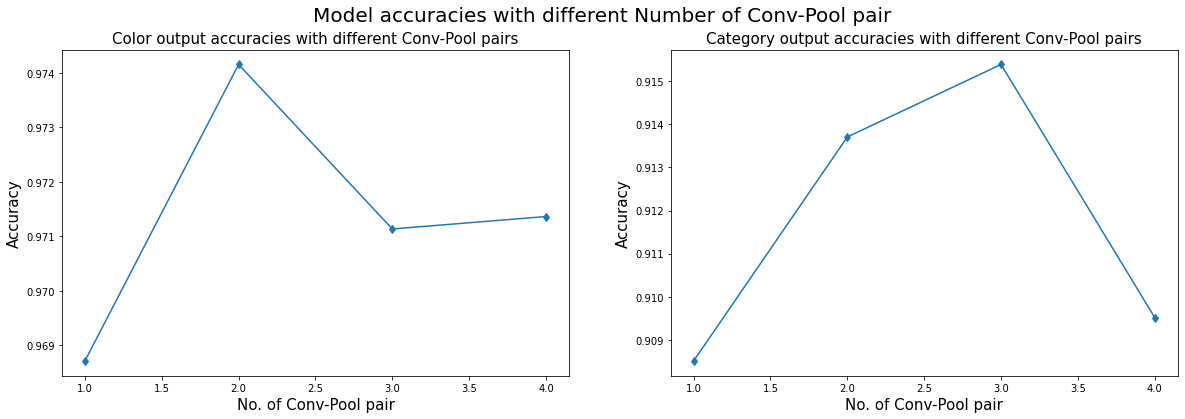

In [ ]:
# Plotting
conv_pool_layers = [1,2,3,4]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plt.suptitle("Model accuracies with different Number of Conv-Pool pair", fontsize=20)

ax[0].plot(conv_pool_layers, mean_val_color_acc, marker='d')
ax[0].set_title('Color output accuracies with different Conv-Pool pairs', fontsize=15)
ax[0].set_xlabel('No. of Conv-Pool pair', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)

ax[1].plot(conv_pool_layers, mean_val_category_acc, marker='d')
ax[1].set_title('Category output accuracies with different Conv-Pool pairs', fontsize=15)
ax[1].set_xlabel('No. of Conv-Pool pair', fontsize=15)
ax[1].set_ylabel('Accuracy', fontsize=15)

plt.show()

### From above plots, we can deduce that the <u>`color` net gave the best accuracy with 2 Conv-Pool pairs and `category` net gave the best accuracy with 3 Conv-Pool pairs</u>.

*Benchmark Score (Color Net) : 97.415*<br>
*Benchmark Score (Category Net) : 91.538*

<a id='14'></a>
## 4.3 Choosing the right batch size and epochs

### NOTE : For no. of epochs, I am going to use early Stopping callback rather than experimenting to found out a fixed number of epochs best suited for this problem.

Now, let's see which batch size gives us the best result. I am going to try out below batch sizes :

BAtch sizes = [8, 16, 32, 64, 128, 256]

In [ ]:
N_BATCH_SIZE = 6
model = [0] * N_BATCH_SIZE
history = [0] * N_BATCH_SIZE

In [ ]:
def build_color_net(inputs):
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def build_category_net(inputs):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs) 
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width):
  inputShape = (height, width, 3)
  inputs = Input(shape = inputShape)

  colorClassifier = build_color_net(inputs)
  categoryClassifier = build_category_net(inputs)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
model_labels = []
batch_size_list = [8, 16, 32, 64, 128, 256]
for i in range(N_BATCH_SIZE):
  model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1])
  model_name = "model_batch_size_" + str(batch_size_list[i])
  model_labels.append(model_name)
  i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_BATCH_SIZE):
  print(f"Fitting model : {i+1}/{N_BATCH_SIZE}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=batch_size_list[i],
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/6
Epoch 1/500
253/253 - 2s - loss: 0.8633 - color_output_loss: 0.3387 - category_output_loss: 0.5246 - color_output_accuracy: 0.9272 - category_output_accuracy: 0.8188 - val_loss: 0.3436 - val_color_output_loss: 0.0846 - val_category_output_loss: 0.2590 - val_color_output_accuracy: 0.9703 - val_category_output_accuracy: 0.9050
Epoch 2/500
253/253 - 2s - loss: 0.3699 - color_output_loss: 0.1191 - category_output_loss: 0.2508 - color_output_accuracy: 0.9634 - category_output_accuracy: 0.9238 - val_loss: 0.3434 - val_color_output_loss: 0.0766 - val_category_output_loss: 0.2668 - val_color_output_accuracy: 0.9703 - val_category_output_accuracy: 0.9069
Epoch 3/500
253/253 - 2s - loss: 0.2556 - color_output_loss: 0.0620 - category_output_loss: 0.1936 - color_output_accuracy: 0.9787 - category_output_accuracy: 0.9386 - val_loss: 0.3202 - val_color_output_loss: 0.0826 - val_category_output_loss: 0.2377 - val_color_output_accuracy: 0.9762 - val_category_output_accuracy: 0.9287

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_BATCH_SIZE):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

# Computing the overall mean accuracy of model with each batch size
overall_acc = []
for col_acc, cat_acc in zip(mean_val_color_acc, mean_val_category_acc):
  overall_acc.append(np.mean([col_acc, cat_acc]))

In [ ]:
# Scoring Dataframe
batch_size_df = pd.DataFrame({
    'Batch Size' : model_labels,
    'Overall Accuracy' : overall_acc
})

In [ ]:
batch_size_df.sort_values(by='Overall Accuracy', ascending=False)

,Batch Size,Overall Accuracy
1,model_batch_size_16,0.952835
2,model_batch_size_32,0.945773
0,model_batch_size_8,0.944455
3,model_batch_size_64,0.943234
4,model_batch_size_128,0.927761
5,model_batch_size_256,0.925770


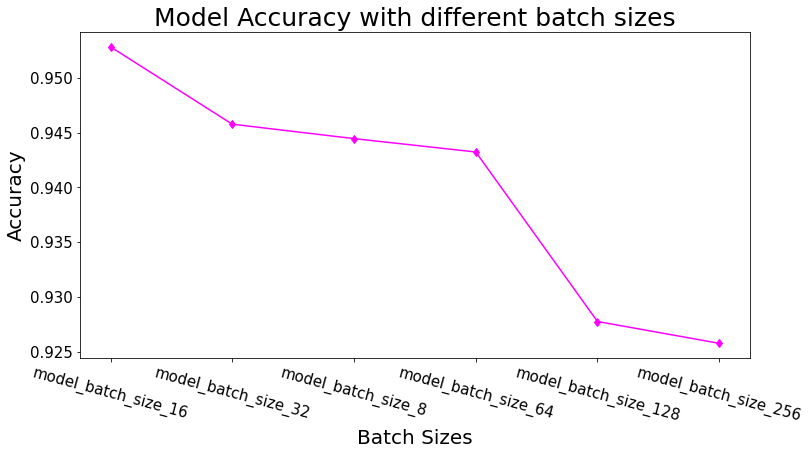

In [ ]:
plt.figure(figsize=(12,6))
sorted_df = batch_size_df.sort_values(by='Overall Accuracy', ascending=False)
plt.title("Model Accuracy with different batch sizes", fontsize=25)
plt.plot(sorted_df['Batch Size'], sorted_df['Overall Accuracy'], marker='d', color='magenta')
plt.xlabel('Batch Sizes', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=15, rotation=-15)
plt.yticks(fontsize=15)
plt.show()

### <u>A Batch Size of 16 gave the best model accuracy</u>. Moving further, we will have batch_size=16 in all experiments

<a id='15'></a>
## 4.4 Choosing right number of Feature Maps/ Filters:

In the previous experiement, we decided that 2 pairs in Color Net and 3 pairs in Category Net of Conv-Pool pair are sufficient. How many feature maps should we include? For example, we could try below configurations:

Color Net : 
* INPUT - **[8C5-P2] - [16C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[16C5-P2] - [32C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[24C5-P2] - [48C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[32C5-P2] - [64C5-P2]** - FLATTEN - DENSE - OUTPUT


Category Net :
* INPUT - **[8C5-P2] - [16C5-P2] - [24C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[16C5-P2] - [32C5-P2] - [48C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[24C5-P2] - [48C5-P2] - [72C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[32C5-P2] - [64C5-P2] - [96C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[40C5-P2] - [80C5-P2] - [120C5-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[48C5-P2] - [96C5-P2] - [144C5-P2]** - FLATTEN - DENSE - OUTPUT

Total 24 models => 4 color nets * 6 category nets

In [ ]:
N_COLOR_CONFIGS = 4
N_CATEGORY_CONFIGS = 6
N_TOTAL = N_COLOR_CONFIGS * N_CATEGORY_CONFIGS
model = [0] * N_TOTAL
history = [0] * N_TOTAL

In [ ]:
def build_color_net(inputs, color_conf):
  if color_conf == 1:
    x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  elif color_conf == 2:
    x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=32, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  elif color_conf == 3:
    x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=48, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  else:
    x = Conv2D(filters=32, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=64, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def build_category_net(inputs, cat_conf):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  if cat_conf == 1:
    x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  elif cat_conf == 2:
    x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=32, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=48, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  elif cat_conf == 3:
    x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=48, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=72, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  elif cat_conf == 3:
    x = Conv2D(filters=32, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=64, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=96, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  elif cat_conf == 3:
    x = Conv2D(filters=40, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=80, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=120, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  else:
    x = Conv2D(filters=48, kernel_size=(5,5), padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=96, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(filters=144, kernel_size=(5,5), padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width, color_conf, category_conf):
  inputShape = (height, width, 3)
  inputs = Input(shape = inputShape)

  colorClassifier = build_color_net(inputs, color_conf)
  categoryClassifier = build_category_net(inputs, category_conf)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
model_labels = []
color_conf_list = [1, 2, 3, 4]
category_conf_list = [1, 2, 3, 4, 5, 6]
for color_conf in color_conf_list:
  for category_conf in category_conf_list:
    model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], color_conf, category_conf)
    model_name = "ColorConf_" + str(color_conf) + "_CatConf_" + str(category_conf)
    model_labels.append(model_name)
    i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_TOTAL):
  print(f"Fitting model : {i+1}/{N_TOTAL}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/24
Epoch 1/500
127/127 - 1s - loss: 0.9979 - color_output_loss: 0.4989 - category_output_loss: 0.4990 - color_output_accuracy: 0.9124 - category_output_accuracy: 0.8436 - val_loss: 0.2795 - val_color_output_loss: 0.0780 - val_category_output_loss: 0.2015 - val_color_output_accuracy: 0.9644 - val_category_output_accuracy: 0.9228
Epoch 2/500
127/127 - 1s - loss: 0.2756 - color_output_loss: 0.0593 - category_output_loss: 0.2163 - color_output_accuracy: 0.9792 - category_output_accuracy: 0.9282 - val_loss: 0.3162 - val_color_output_loss: 0.1101 - val_category_output_loss: 0.2061 - val_color_output_accuracy: 0.9545 - val_category_output_accuracy: 0.9228
Epoch 3/500
127/127 - 1s - loss: 0.2493 - color_output_loss: 0.0593 - category_output_loss: 0.1900 - color_output_accuracy: 0.9772 - category_output_accuracy: 0.9351 - val_loss: 0.2456 - val_color_output_loss: 0.0747 - val_category_output_loss: 0.1709 - val_color_output_accuracy: 0.9723 - val_category_output_accuracy: 0.946

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_TOTAL):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
feature_maps_df = pd.DataFrame({
    'Model Configuration' : model_labels,
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
feature_maps_df.sort_values(by='Color accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
5,ColorConf_1_CatConf_6,0.979538,0.925119
15,ColorConf_3_CatConf_4,0.976238,0.925203
8,ColorConf_2_CatConf_3,0.975968,0.937084
9,ColorConf_2_CatConf_4,0.975955,0.935219
17,ColorConf_3_CatConf_6,0.975213,0.919836


In [ ]:
feature_maps_df.sort_values(by='Category accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
6,ColorConf_2_CatConf_1,0.965677,0.955908
0,ColorConf_1_CatConf_1,0.967597,0.950855
12,ColorConf_3_CatConf_1,0.968458,0.950778
19,ColorConf_4_CatConf_2,0.974085,0.949548
14,ColorConf_3_CatConf_3,0.971107,0.948875


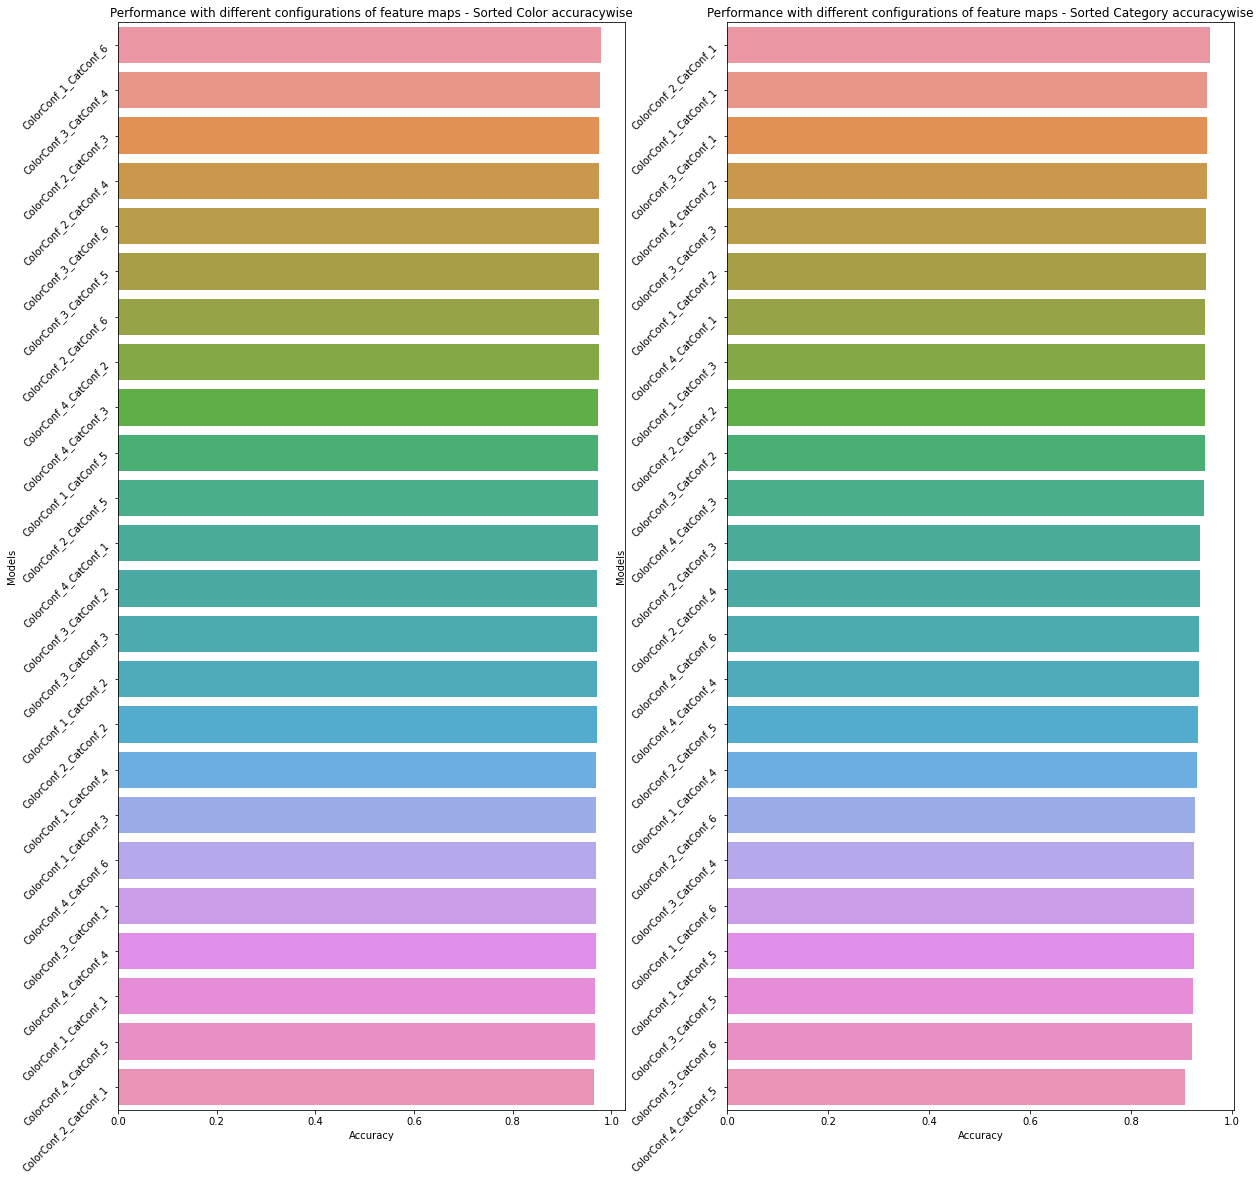

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
feature_maps_color_sort = feature_maps_df.sort_values(by='Color accuracies', ascending=False)
feature_maps_category_sort = feature_maps_df.sort_values(by='Category accuracies', ascending=False)

ax[0].set_title('Performance with different configurations of feature maps - Sorted Color accuracywise')
sns.barplot(feature_maps_color_sort['Color accuracies'], feature_maps_color_sort['Model Configuration'], ax=ax[0])
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Models')
ax[0].set_yticklabels(feature_maps_color_sort['Model Configuration'], rotation=45)

ax[1].set_title('Performance with different configurations of feature maps - Sorted Category accuracywise')
sns.barplot(feature_maps_category_sort['Category accuracies'], feature_maps_category_sort['Model Configuration'], ax=ax[1])
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('Models')
ax[1].set_yticklabels(feature_maps_category_sort['Model Configuration'], rotation=45)

plt.show()

### Config 1 for color model i.e. [INPUT - **[8C5-P2] - [16C5-P2]** - FLATTEN - DENSE - OUTPUT] and Config 1 for category model i.e. [INPUT - **[8C5-P2] - [16C5-P2] - [24C5-P2]** - FLATTEN - DENSE - OUTPUT] gave best accuracies for color net and category net respectively.

*Color Net Benchmark Accuracy : 97.954*<br>
*Category Net Benchmark Accuracy : 95.590*


<a id='16'></a>
## 4.5 Choosing right number of kernel size of feature maps/filters
 
In the previous experiement, we found out that [INPUT - [8C5-P2] - [16C5-P2] - FLATTEN - DENSE - OUTPUT] configuration for color net and [INPUT - [8C5-P2] - [16C5-P2] - [24C5-P2] - FLATTEN - DENSE - OUTPUT] configuration for category net gave the best accuracies. What should be the size of filter for Conv layer? For example, we could try out below configurations:

Color Net:
* INPUT - **[8C2-P2] - [16C2-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[8C3-P2] - [16C3-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[8C5-P2] - [16C5-P2]** - FLATTEN - DENSE - OUTPUT

Category Net:
* INPUT - **[8C2-P2] - [16C2-P2] - [24C2-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[8C3-P2] - [16C3-P2] - [24C3-P2]** - FLATTEN - DENSE - OUTPUT
* INPUT - **[8C5-P2] - [16C5-P2] - [24C5-P2]** - FLATTEN - DENSE - OUTPUT

In [ ]:
N_CONFIGS_COLOR = 3
N_CONFIGS_CATEGORY = 3
N_TOTAL = N_CONFIGS_COLOR * N_CONFIGS_CATEGORY
model = [0] * N_TOTAL
history = [0] * N_TOTAL

In [ ]:
def build_color_net(inputs, k_col):
  x = Conv2D(filters=8, kernel_size=(k_col,k_col), padding='same')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(filters=16, kernel_size=(k_col,k_col), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def build_category_net(inputs, k_cat):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(k_cat,k_cat), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(filters=16, kernel_size=(k_cat,k_cat), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(filters=24, kernel_size=(k_cat,k_cat), padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width, k_col, k_cat):
  inputShape = (height, width, 3)
  inputs = Input(shape = inputShape)

  colorClassifier = build_color_net(inputs, k_col)
  categoryClassifier = build_category_net(inputs, k_cat)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
model_labels = []
color_kernels_list = [2, 3, 5]
category_kernels_list = [2, 3, 5]
for k_col in color_kernels_list:
  for k_cat in category_kernels_list:
    model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], k_col, k_cat)
    model_name = "ColorKernel_" + str(k_col) + "_CatKernel_" + str(k_cat)
    model_labels.append(model_name)
    i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_TOTAL):
  print(f"Fitting model : {i+1}/{N_TOTAL}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/9
Epoch 1/500
127/127 - 1s - loss: 2.4303 - color_output_loss: 1.8073 - category_output_loss: 0.6230 - color_output_accuracy: 0.8525 - category_output_accuracy: 0.8144 - val_loss: 0.3808 - val_color_output_loss: 0.1122 - val_category_output_loss: 0.2686 - val_color_output_accuracy: 0.9663 - val_category_output_accuracy: 0.9129
Epoch 2/500
127/127 - 1s - loss: 0.3477 - color_output_loss: 0.0756 - category_output_loss: 0.2722 - color_output_accuracy: 0.9743 - category_output_accuracy: 0.9104 - val_loss: 0.3970 - val_color_output_loss: 0.1420 - val_category_output_loss: 0.2549 - val_color_output_accuracy: 0.9327 - val_category_output_accuracy: 0.9129
Epoch 3/500
127/127 - 1s - loss: 0.2705 - color_output_loss: 0.0532 - category_output_loss: 0.2173 - color_output_accuracy: 0.9842 - category_output_accuracy: 0.9312 - val_loss: 0.3060 - val_color_output_loss: 0.0800 - val_category_output_loss: 0.2260 - val_color_output_accuracy: 0.9782 - val_category_output_accuracy: 0.9208

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_TOTAL):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
kernel_size_df = pd.DataFrame({
    'Model Configuration' : model_labels,
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
kernel_size_df.sort_values(by='Color accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
5,ColorKernel_3_CatKernel_5,0.978218,0.934851
7,ColorKernel_5_CatKernel_3,0.977138,0.927453
2,ColorKernel_2_CatKernel_5,0.974257,0.934406
4,ColorKernel_3_CatKernel_3,0.973069,0.919802
1,ColorKernel_2_CatKernel_3,0.972871,0.920792


In [ ]:
kernel_size_df.sort_values(by='Category accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
5,ColorKernel_3_CatKernel_5,0.978218,0.934851
3,ColorKernel_3_CatKernel_2,0.966139,0.934455
2,ColorKernel_2_CatKernel_5,0.974257,0.934406
6,ColorKernel_5_CatKernel_2,0.971197,0.932313
7,ColorKernel_5_CatKernel_3,0.977138,0.927453


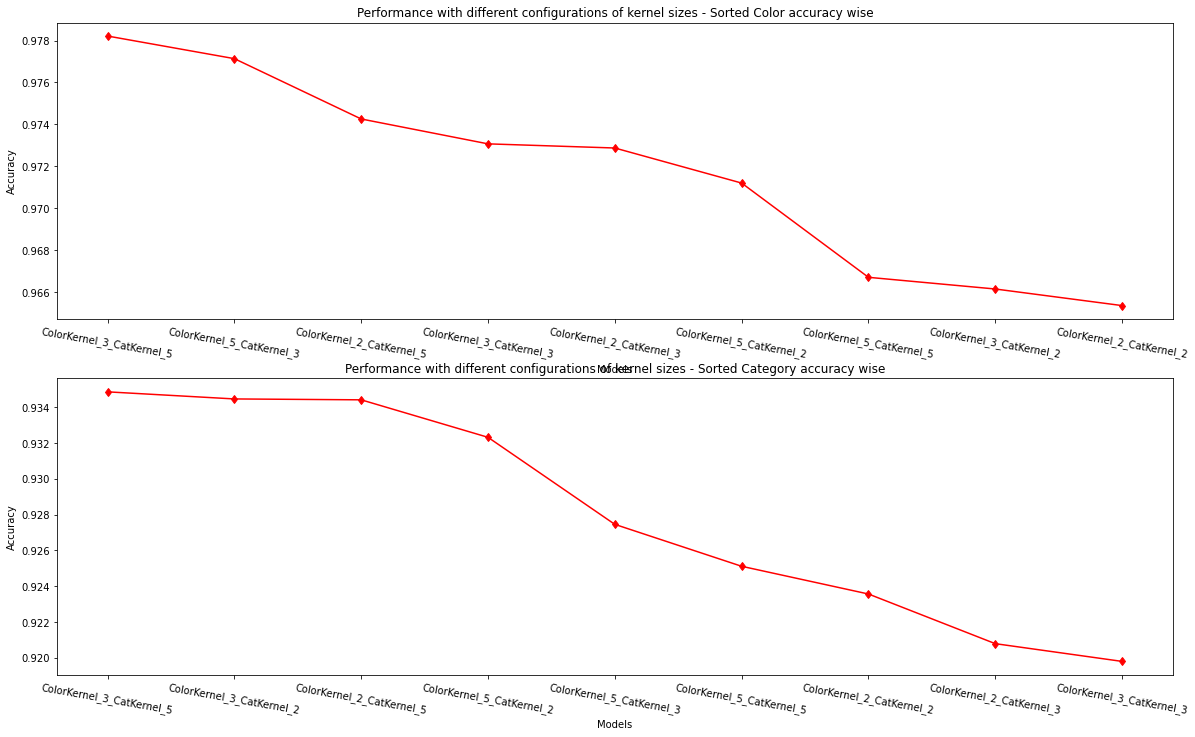

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
kernel_size_color_sort = kernel_size_df.sort_values(by='Color accuracies', ascending=False)
kernel_size_category_sort = kernel_size_df.sort_values(by='Category accuracies', ascending=False)

ax[0].set_title('Performance with different configurations of kernel sizes - Sorted Color accuracy wise')
ax[0].plot(kernel_size_color_sort['Model Configuration'], kernel_size_color_sort['Color accuracies'], marker='d', color='red')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(kernel_size_color_sort['Model Configuration'], rotation=-10)

ax[1].set_title('Performance with different configurations of kernel sizes - Sorted Category accuracy wise')
ax[1].plot(kernel_size_category_sort['Model Configuration'], kernel_size_category_sort['Category accuracies'], marker='d', color='red')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticklabels(kernel_size_category_sort['Model Configuration'], rotation=-10)

plt.show()

### A Kernel size of 3 in Color Net and kernel size of 5 in Category Net gave hebest accuracies.
Moving forward, we will use the below configurations for further experiments :

* Color Net : INPUT - [8C3-P2] - [16C3-P2] - FLATTEN - DENSE - OUTPUT

* Category Net : INPUT - [8C5-P2] - [16C5-P2] - [24C5-P2] - FLATTEN - DENSE - OUTPUT

*Color Net Benchmark Accuracy : 97.8218*<br>
*Category Net Benchmark Accuracy : 93.4851*

<a id='17'></a>
## 4.6 Choosing the right pool size

We got 3 as the best kernel size for Conv layers in both color and category nets. What is the optimal size of pool in max pool layer? For eg, we can try out below configs:

Color Net : 
* INPUT - [8C3-P2] - [16C3-P2] - FLATTEN - DENSE - OUTPUT
* INPUT - [8C3-P3] - [16C3-P3] - FLATTEN - DENSE - OUTPUT
* INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE - OUTPUT

Category Net :
* INPUT - [8C5-P2] - [16C5-P2] - [24C5-P2] - FLATTEN - DENSE - OUTPUT
* INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE - OUTPUT
* INPUT - [8C5-P5] - [16C5-P5] - [24C5-P5] - FLATTEN - DENSE - OUTPUT 

In [ ]:
N_CONFIGS_COLOR = 3
N_CONFIGS_CATEGORY = 3
N_TOTAL = N_CONFIGS_COLOR * N_CONFIGS_CATEGORY
model = [0] * N_TOTAL
history = [0] * N_TOTAL

In [ ]:
def build_color_net(inputs, p_col):
  x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
  x = MaxPooling2D(pool_size=(p_col,p_col), padding='same')(x)
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
  x = MaxPooling2D(pool_size=(p_col,p_col), padding='same')(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def build_category_net(inputs, p_cat):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(p_cat,p_cat), padding='same')(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(p_cat,p_cat), padding='same')(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(p_cat,p_cat), padding='same')(x)
  x = Flatten()(x)
  x = Dense(units=128)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width, p_col, p_cat):
  inputShape = (height, width, 3)
  inputs = Input(shape = inputShape)

  colorClassifier = build_color_net(inputs, p_col)
  categoryClassifier = build_category_net(inputs, p_cat)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
model_labels = []
color_poolsize_list = [2, 3, 5]
category_poolsize_list = [2, 3, 5]
for p_col in color_poolsize_list:
  for p_cat in category_poolsize_list:
    model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], p_col, p_cat)
    model_name = "ColorPool_" + str(p_col) + "_CatPool_" + str(p_cat)
    model_labels.append(model_name)
    i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_TOTAL):
  print(f"Fitting model : {i+1}/{N_TOTAL}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/9
Epoch 1/500
127/127 - 1s - loss: 0.9111 - color_output_loss: 0.3181 - category_output_loss: 0.5929 - color_output_accuracy: 0.9252 - category_output_accuracy: 0.8124 - val_loss: 0.3509 - val_color_output_loss: 0.0821 - val_category_output_loss: 0.2688 - val_color_output_accuracy: 0.9762 - val_category_output_accuracy: 0.9089
Epoch 2/500
127/127 - 1s - loss: 0.3326 - color_output_loss: 0.0406 - category_output_loss: 0.2920 - color_output_accuracy: 0.9861 - category_output_accuracy: 0.9020 - val_loss: 0.3437 - val_color_output_loss: 0.1035 - val_category_output_loss: 0.2401 - val_color_output_accuracy: 0.9525 - val_category_output_accuracy: 0.9267
Epoch 3/500
127/127 - 1s - loss: 0.2609 - color_output_loss: 0.0321 - category_output_loss: 0.2288 - color_output_accuracy: 0.9876 - category_output_accuracy: 0.9203 - val_loss: 0.2966 - val_color_output_loss: 0.0769 - val_category_output_loss: 0.2197 - val_color_output_accuracy: 0.9802 - val_category_output_accuracy: 0.9208

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_TOTAL):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
pool_size_df = pd.DataFrame({
    'Model Configuration' : model_labels,
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
pool_size_df.sort_values(by='Color accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
6,ColorPool_5_CatPool_2,0.982772,0.928911
8,ColorPool_5_CatPool_5,0.978438,0.933113
7,ColorPool_5_CatPool_3,0.977970,0.933416
1,ColorPool_2_CatPool_3,0.975248,0.949109
0,ColorPool_2_CatPool_2,0.973020,0.917574


In [ ]:
pool_size_df.sort_values(by='Category accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
1,ColorPool_2_CatPool_3,0.975248,0.949109
4,ColorPool_3_CatPool_3,0.966337,0.944307
5,ColorPool_3_CatPool_5,0.971557,0.940234
2,ColorPool_2_CatPool_5,0.971122,0.936634
7,ColorPool_5_CatPool_3,0.977970,0.933416


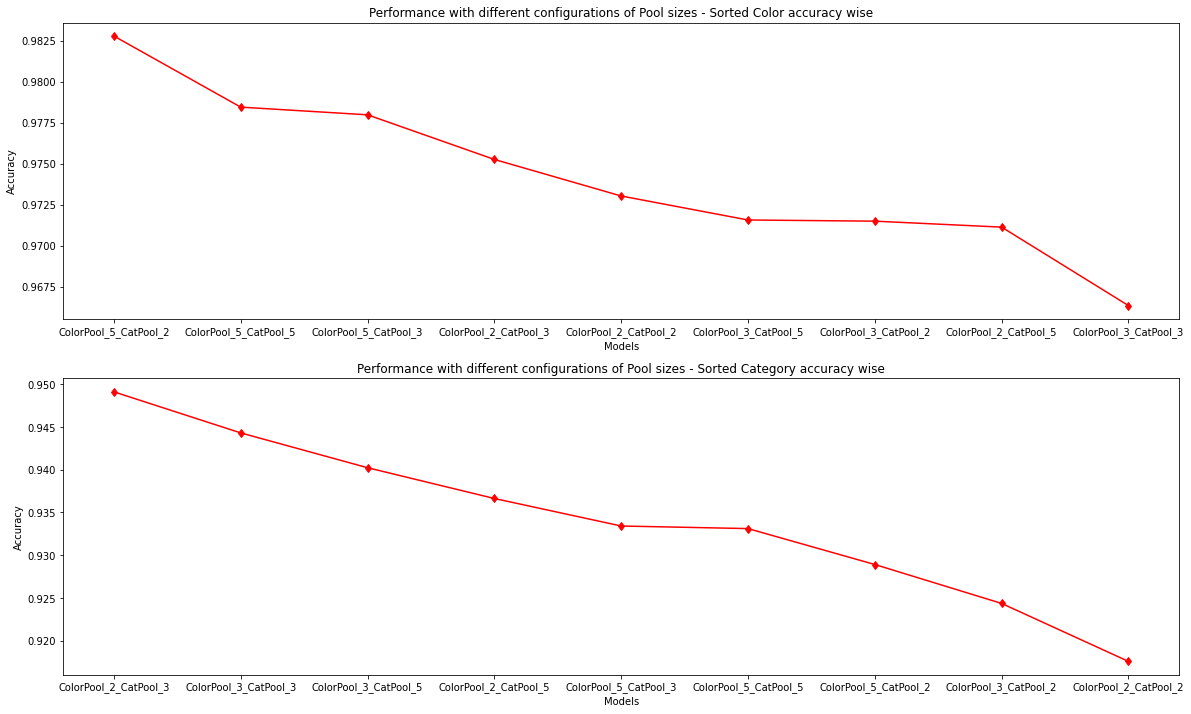

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
pool_size_color_sort = pool_size_df.sort_values(by='Color accuracies', ascending=False)
pool_size_category_sort = pool_size_df.sort_values(by='Category accuracies', ascending=False)

ax[0].set_title('Performance with different configurations of Pool sizes - Sorted Color accuracy wise')
ax[0].plot(pool_size_color_sort['Model Configuration'], pool_size_color_sort['Color accuracies'], marker='d', color='red')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(pool_size_color_sort['Model Configuration'])

ax[1].set_title('Performance with different configurations of Pool sizes - Sorted Category accuracy wise')
ax[1].plot(pool_size_category_sort['Model Configuration'], pool_size_category_sort['Category accuracies'], marker='d', color='red')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticklabels(pool_size_category_sort['Model Configuration'])

plt.show()

## Models having <u>pool size of 5 in Color Net</u> and <u>pool size of 3 in Category Net</u> gave the best accuracies. 

Moving forward, we will use the below configurations for further experiments :

* Color Net : INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE - OUTPUT

* Category Net : INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE - OUTPUT

*Color Net Benchmark Score : 98.2772*<br>
*Category Net Benchmark Score : 94.9109*

<a id='18'></a>
## 4.7 Choosing Dense layer units
 
In the previous experiement, we saw that a Pool size of 5x5 in Color Net and Pool size of 3x3 in Category Net gave the best results. What should be the appropriate size of Dense layer to be used? For example, we could try out below configs:

Color Net:
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(16) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(32) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(64) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(128) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(256) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(512) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(1024) - OUTPUT
* INPUT - **[8C3-P5] - [16C3-P5]** - FLATTEN - DENSE(2048) - OUTPUT

Category Net:
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(16) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(32) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(64) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(128) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(256) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(512) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(1024) - OUTPUT
* INPUT - **[8C5-P3] - [16C5-P3] - [24C5-P3]** - FLATTEN - DENSE(2048) - OUTPUT



In [ ]:
N_DENSE_UNITS_COLORS = 8
N_DENSE_UNITS_CATEGORY = 8
N_TOTAL = N_DENSE_UNITS_COLORS * N_DENSE_UNITS_CATEGORY
model = [0] * N_TOTAL
history = [0] * N_TOTAL

In [ ]:
def build_color_net(inputs, dense_units_col):
  x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
  x = MaxPooling2D(pool_size=(5,5), padding='same')(x)
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
  x = MaxPooling2D(pool_size=(5,5), padding='same')(x)
  x = Flatten()(x)
  x = Dense(units=dense_units_col)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def build_category_net(inputs, dense_units_cat):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(3,3), padding='same')(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(3,3), padding='same')(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(3,3), padding='same')(x)
  x = Flatten()(x)
  x = Dense(units=dense_units_cat)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width, dense_units_col, dense_units_cat):
  inputShape = (height, width, 3)
  inputs = Input(shape = inputShape)

  colorClassifier = build_color_net(inputs, dense_units_col)
  categoryClassifier = build_category_net(inputs, dense_units_cat)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
model_labels = []
color_dense_units = [16, 32, 64, 128, 256, 512, 1024, 2048]
category_dense_units = [16, 32, 64, 128, 256, 512, 1024, 2048]
for dense_units_col in color_dense_units:
  for dense_units_cat in category_dense_units:
    model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], dense_units_col, dense_units_cat)
    model_name = "ColorDenseUnits_" + str(dense_units_col) + "_CatDenseUnits_" + str(dense_units_cat)
    model_labels.append(model_name)
    i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_TOTAL):
  print(f"Fitting model : {i+1}/{N_TOTAL}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/64
Epoch 1/500
135/135 - 1s - loss: 1.0695 - color_output_loss: 0.4914 - category_output_loss: 0.5781 - color_output_accuracy: 0.8155 - category_output_accuracy: 0.7835 - val_loss: 0.4003 - val_color_output_loss: 0.1363 - val_category_output_loss: 0.2640 - val_color_output_accuracy: 0.9703 - val_category_output_accuracy: 0.9201
Epoch 2/500
135/135 - 1s - loss: 0.4222 - color_output_loss: 0.1298 - category_output_loss: 0.2924 - color_output_accuracy: 0.9507 - category_output_accuracy: 0.9015 - val_loss: 0.3641 - val_color_output_loss: 0.0923 - val_category_output_loss: 0.2718 - val_color_output_accuracy: 0.9758 - val_category_output_accuracy: 0.8922
Epoch 3/500
135/135 - 1s - loss: 0.3213 - color_output_loss: 0.0960 - category_output_loss: 0.2253 - color_output_accuracy: 0.9679 - category_output_accuracy: 0.9247 - val_loss: 0.2325 - val_color_output_loss: 0.0675 - val_category_output_loss: 0.1650 - val_color_output_accuracy: 0.9796 - val_category_output_accuracy: 0.949

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_TOTAL):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
dense_units_df = pd.DataFrame({
    'Model Configuration' : model_labels,
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
dense_units_df.sort_values(by='Color accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
15,ColorDenseUnits_32_CatDenseUnits_2048,0.990939,0.937500
8,ColorDenseUnits_32_CatDenseUnits_16,0.990706,0.942379
13,ColorDenseUnits_32_CatDenseUnits_512,0.990706,0.932672
3,ColorDenseUnits_16_CatDenseUnits_128,0.989467,0.942792
24,ColorDenseUnits_128_CatDenseUnits_16,0.989467,0.941966


In [ ]:
dense_units_df.sort_values(by='Category accuracies', ascending=False).head()

,Model Configuration,Color accuracies,Category accuracies
57,ColorDenseUnits_2048_CatDenseUnits_32,0.981289,0.954027
40,ColorDenseUnits_512_CatDenseUnits_16,0.983891,0.950744
41,ColorDenseUnits_512_CatDenseUnits_32,0.988848,0.950434
45,ColorDenseUnits_512_CatDenseUnits_512,0.988228,0.950021
17,ColorDenseUnits_64_CatDenseUnits_32,0.986417,0.949671


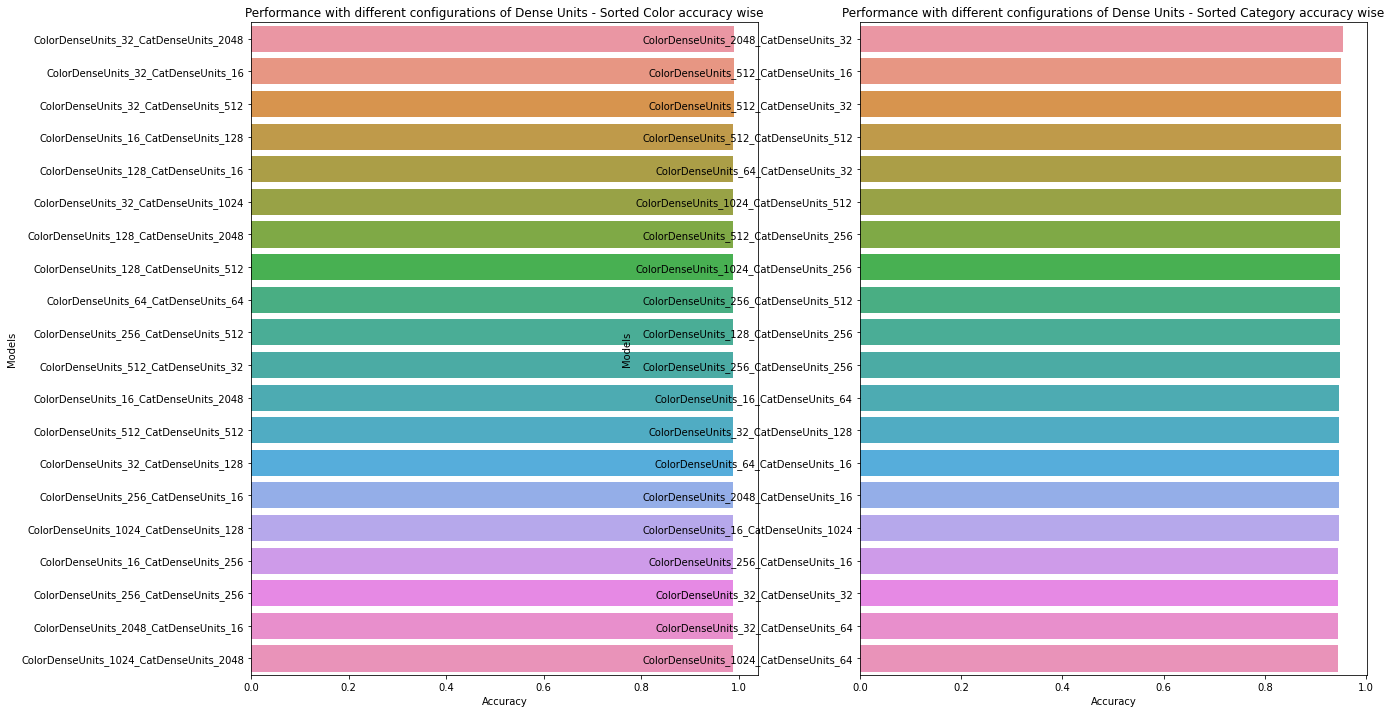

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,12))
dense_units_color_sort = dense_units_df.sort_values(by='Color accuracies', ascending=False).head(20)
dense_units_category_sort = dense_units_df.sort_values(by='Category accuracies', ascending=False).head(20)

ax[0].set_title('Performance with different configurations of Dense Units - Sorted Color accuracy wise')
# ax[0].plot(pool_size_color_sort['Model Configuration'], pool_size_color_sort['Color accuracies'], marker='d', color='red')
sns.barplot(dense_units_color_sort['Color accuracies'], dense_units_color_sort['Model Configuration'], ax=ax[0])
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Models')
# ax[0].set_yticklabels(pool_size_color_sort['Model Configuration'])

ax[1].set_title('Performance with different configurations of Dense Units - Sorted Category accuracy wise')
# ax[1].plot(pool_size_category_sort['Model Configuration'], pool_size_category_sort['Category accuracies'], marker='d', color='red')
sns.barplot(dense_units_category_sort['Category accuracies'], dense_units_category_sort['Model Configuration'], ax=ax[1])
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('Models')
# ax[1].set_xticklabels(pool_size_category_sort['Model Configuration'])

plt.show()

### <u>32 Dense hidden units in both Color and Category Net</u> gave the best accuracies.
Moving forward, we will use the below configurations for further experiments :

* Color Net : INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE(32) - OUTPUT

* Category Net : INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE(32) - OUTPUT

*Color Net Benchmark accuracy : 99.0939*<br>
*Category Net Benchmark accuracy : 95.4027*


<a id='19'></a>
## 4.8 Choosing right number of Dense layers
 
In the previous experiement, we saw that a Dense layer with 32 units gave the best results for both Category and Color Net. What should be the appropriate number of Dense layers to be used? For example, we could do

Color Net :
* INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE(32) - OUTPUT
* INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE(32) - DENSE(16) - OUTPUT
* INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE(32) - DENSE(16) - DENSE(8) - OUTPUT

Category Net :
* INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE(32) - OUTPUT
* INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE(32) - DENSE(16) - OUTPUT
* INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE(32) - DENSE(16) - DENSE(8) - OUTPUT

In [ ]:
N_DENSE_LAYERS_COLORNET = 3
N_DENSE_LAYERS_CATNET = 3
N_TOTAL = N_DENSE_LAYERS_COLORNET * N_DENSE_LAYERS_CATNET
model = [0] * N_TOTAL
history = [0] * N_TOTAL

In [ ]:
def color_net(inputs, dense_layers_col):
  x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Flatten()(x)
  if dense_layers_col == 1:
    x = Dense(units=32)(x)
  elif dense_layers_col == 2:
    x = Dense(units=32)(x)
    x = Dense(units=16)(x)
  else:
    x = Dense(units=32)(x)
    x = Dense(units=16)(x)
    x = Dense(units=8)(x)
  x = Dense(units=NUM_COLORS, activation='softmax', name='color_output')(x)
  return x


def category_net(inputs, dense_layers_cat):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Flatten()(x)
  if dense_layers_cat == 1:
    x = Dense(units=32)(x)
  elif dense_layers_cat == 2:
    x = Dense(units=32)(x)
    x = Dense(units=16)(x)
  else:
    x = Dense(units=32)(x)
    x = Dense(units=16)(x)
    x = Dense(units=8)(x)
  x = Dense(units=NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x


def build_model(height, width, dense_layers_col, dense_layers_cat):
  inputShape = (height, width, 3)
  inputs = Input(shape=inputShape)

  colorClassifier = color_net(inputs, dense_layers_col)
  categoryClassifier = category_net(inputs, dense_layers_cat)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
model_labels = []
color_dense_layers = [1, 2, 3]
category_dense_layers = [1, 2, 3]
for dense_layers_col in color_dense_layers:
  for dense_layers_cat in category_dense_layers:
    model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], dense_layers_col, dense_layers_cat)
    model_name = "ColorDL_" + str(dense_layers_col) + "_CatDL_" + str(dense_layers_cat)
    model_labels.append(model_name)
    i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_TOTAL):
  print(f"Fitting model : {i+1}/{N_TOTAL}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/9
Epoch 1/500
135/135 - 1s - loss: 0.9128 - color_output_loss: 0.3374 - category_output_loss: 0.5754 - color_output_accuracy: 0.8903 - category_output_accuracy: 0.7965 - val_loss: 0.4041 - val_color_output_loss: 0.1114 - val_category_output_loss: 0.2927 - val_color_output_accuracy: 0.9647 - val_category_output_accuracy: 0.8978
Epoch 2/500
135/135 - 1s - loss: 0.3876 - color_output_loss: 0.1019 - category_output_loss: 0.2857 - color_output_accuracy: 0.9651 - category_output_accuracy: 0.9066 - val_loss: 0.3047 - val_color_output_loss: 0.0682 - val_category_output_loss: 0.2365 - val_color_output_accuracy: 0.9814 - val_category_output_accuracy: 0.9275
Epoch 3/500
135/135 - 1s - loss: 0.2795 - color_output_loss: 0.0620 - category_output_loss: 0.2174 - color_output_accuracy: 0.9791 - category_output_accuracy: 0.9252 - val_loss: 0.2445 - val_color_output_loss: 0.0481 - val_category_output_loss: 0.1965 - val_color_output_accuracy: 0.9888 - val_category_output_accuracy: 0.9349

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_TOTAL):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
dense_layers_df = pd.DataFrame({
    'Dense Layers' : model_labels,
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
dense_layers_df.sort_values(by='Color accuracies', ascending=False).head()

,Dense Layers,Color accuracies,Category accuracies
6,ColorDL_3_CatDL_1,0.988051,0.943840
1,ColorDL_1_CatDL_2,0.986245,0.931041
4,ColorDL_2_CatDL_2,0.985956,0.937010
0,ColorDL_1_CatDL_1,0.985845,0.936660
8,ColorDL_3_CatDL_3,0.983947,0.933761


In [ ]:
dense_layers_df.sort_values(by='Category accuracies', ascending=False).head()

,Dense Layers,Color accuracies,Category accuracies
2,ColorDL_1_CatDL_3,0.983271,0.948988
6,ColorDL_3_CatDL_1,0.988051,0.943840
5,ColorDL_2_CatDL_3,0.983643,0.942565
3,ColorDL_2_CatDL_1,0.982156,0.942379
7,ColorDL_3_CatDL_2,0.983736,0.938662


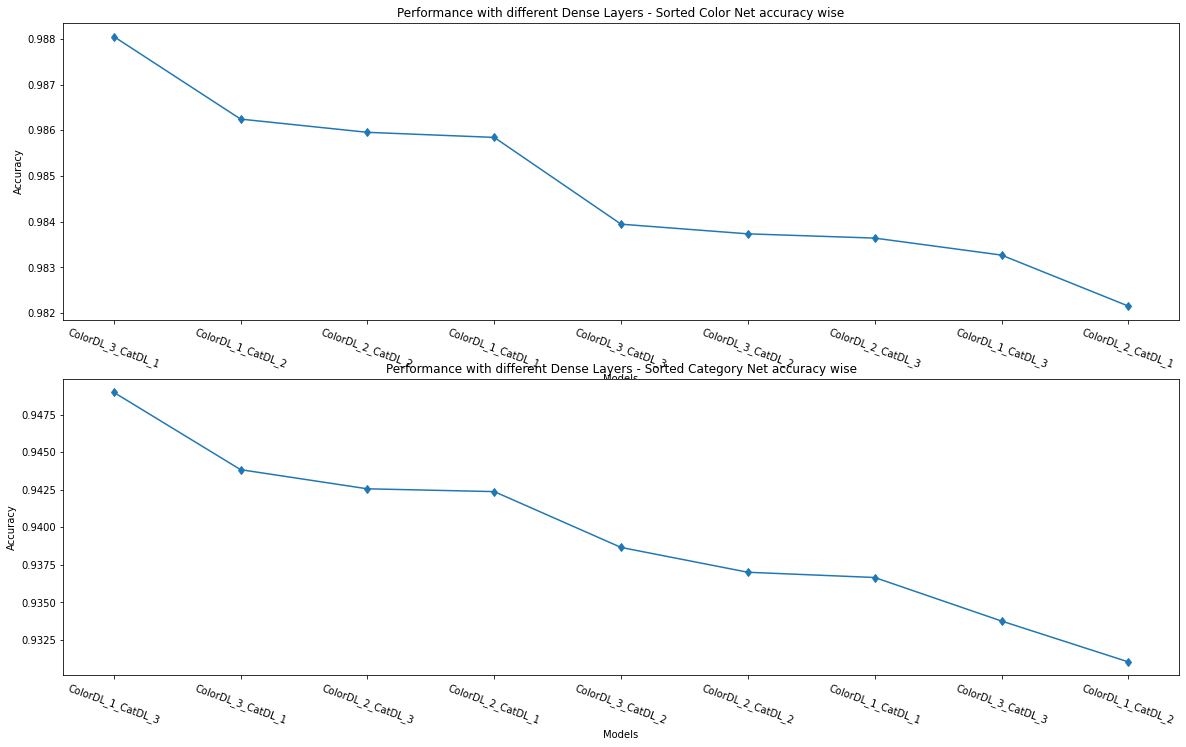

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
dense_layers_color_sort = dense_layers_df.sort_values(by='Color accuracies', ascending=False)
dense_layers_category_sort = dense_layers_df.sort_values(by='Category accuracies', ascending=False)

ax[0].set_title('Performance with different Dense Layers - Sorted Color Net accuracy wise')
ax[0].plot(dense_layers_color_sort['Dense Layers'], dense_layers_color_sort['Color accuracies'], marker='d')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(dense_layers_color_sort['Dense Layers'], rotation=-20)

ax[1].set_title('Performance with different Dense Layers - Sorted Category Net accuracy wise')
ax[1].plot(dense_layers_category_sort['Dense Layers'], dense_layers_category_sort['Category accuracies'], marker='d')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticklabels(dense_layers_category_sort['Dense Layers'], rotation=-20)

plt.show()

### The accuracy from all models is pretty close. Models with <u>3 dense layers in both Color and Category Net</u> gave the best accuracies. 

Moving forward, we will use below configurations:

Color Net : INPUT - [8C3-P5] - [16C3-P5] - FLATTEN - DENSE(32) - DENSE(16) - DENSE(8) - OUTPUT 

Category Net : INPUT - [8C5-P3] - [16C5-P3] - [24C5-P3] - FLATTEN - DENSE(32) - DENSE(16) - DENSE(8) - OUTPUT

*Color Net Benchmark Accuracy : 98.8051*<br>
*Category Net Benchmark Accuracy : 94.8988*

<a id='20'></a>
## 4.9 Which activation is best for us
 
In the previous experiement, we saw that 3 Dense layer for both Color and Category Net gave the best results. What about the activation layer. Let see which activation performs the best. For eg, we can try the below activations:

Activation => [Relu, Tanh, Sigmoid, Softmax]


In [ ]:
N_ACTIVATIONS = 4
model = [0] * N_ACTIVATIONS
history = [0] * N_ACTIVATIONS

In [ ]:
def color_net(inputs, activation):
  x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Flatten()(x)
  x = Dense(units=32)(x)
  x = Activation(activation)(x)
  x = Dense(units=16)(x)
  x = Activation(activation)(x)
  x = Dense(units=8)(x)
  x = Activation(activation)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def category_net(inputs, activation):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Flatten()(x)
  x = Dense(units=32)(x)
  x = Activation(activation)(x)
  x = Dense(units=16)(x)
  x = Activation(activation)(x)
  x = Dense(units=8)(x)
  x = Activation(activation)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width, activation):
  inputShape = (height, width, 3)
  inputs = Input(shape=inputShape)

  colorClassifier = color_net(inputs, activation)
  categoryClassifier = category_net(inputs, activation)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
activations = ['relu', 'tanh', 'softmax', 'sigmoid']
for activation in activations:
  model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], activation)
  i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_ACTIVATIONS):
  print(f"Fitting model : {i+1}/{N_ACTIVATIONS}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/4
Epoch 1/500
135/135 - 1s - loss: 1.4523 - color_output_loss: 0.6185 - category_output_loss: 0.8338 - color_output_accuracy: 0.7388 - category_output_accuracy: 0.6631 - val_loss: 0.5009 - val_color_output_loss: 0.1656 - val_category_output_loss: 0.3353 - val_color_output_accuracy: 0.9461 - val_category_output_accuracy: 0.9089
Epoch 2/500
135/135 - 1s - loss: 0.5128 - color_output_loss: 0.1595 - category_output_loss: 0.3532 - color_output_accuracy: 0.9377 - category_output_accuracy: 0.8769 - val_loss: 0.4316 - val_color_output_loss: 0.1906 - val_category_output_loss: 0.2409 - val_color_output_accuracy: 0.9238 - val_category_output_accuracy: 0.9219
Epoch 3/500
135/135 - 1s - loss: 0.3829 - color_output_loss: 0.1230 - category_output_loss: 0.2599 - color_output_accuracy: 0.9521 - category_output_accuracy: 0.9145 - val_loss: 0.2900 - val_color_output_loss: 0.0840 - val_category_output_loss: 0.2060 - val_color_output_accuracy: 0.9684 - val_category_output_accuracy: 0.9238

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_ACTIVATIONS):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
activation_df = pd.DataFrame({
    'Activation' : activations,
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
activation_df.sort_values(by='Color accuracies', ascending=False).head()

,Activation,Color accuracies,Category accuracies
1,tanh,0.985285,0.945787
0,relu,0.966686,0.933086
3,sigmoid,0.882862,0.677026
2,softmax,0.645267,0.556120


In [ ]:
activation_df.sort_values(by='Category accuracies', ascending=False).head()

,Activation,Color accuracies,Category accuracies
1,tanh,0.985285,0.945787
0,relu,0.966686,0.933086
3,sigmoid,0.882862,0.677026
2,softmax,0.645267,0.556120


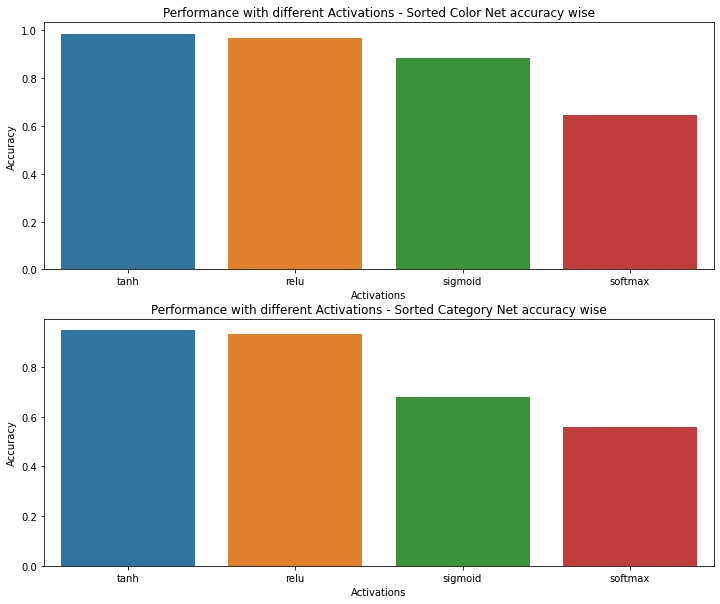

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))
activation_color_sort = activation_df.sort_values(by='Color accuracies', ascending=False)
activation_category_sort = activation_df.sort_values(by='Category accuracies', ascending=False)

ax[0].set_title('Performance with different Activations - Sorted Color Net accuracy wise')
# ax[0].plot(activation_color_sort['Activation'], activation_color_sort['Color accuracies'], marker='d')
sns.barplot(activation_color_sort['Activation'], activation_color_sort['Color accuracies'], ax=ax[0])
ax[0].set_xlabel('Activations')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(activation_color_sort['Activation'])

ax[1].set_title('Performance with different Activations - Sorted Category Net accuracy wise')
# ax[1].plot(activation_category_sort['Activation'], activation_category_sort['Category accuracies'], marker='d')
sns.barplot(activation_category_sort['Activation'], activation_category_sort['Category accuracies'], ax=ax[1])
ax[1].set_xlabel('Activations')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticklabels(activation_category_sort['Activation'])

plt.show()

## <u>Model with Tanh activation in both Color and Category Net performed the best.</u> Moving forward, we will include tanh activation in model architecture.

*Color Net Benchmark accuracy : 98.5285*<br>
*Category Net Benchmark accuracy : 94.5787*

<a id='21'></a>
## 4.10 How much Dropout
 
In the previous experiement, we saw that Tanh activation gave the best results.

Dropout will prevent our network from overfitting thus helping our network generalize better. How much dropout should we add after each layer?

10%, 20%, 25%, 30%, 40%, 50%, 60%, or 70% ?

In [ ]:
N_DROPOUTS = 8
model = [0] * N_DROPOUTS
history = [0] * N_DROPOUTS

In [ ]:
def color_net(inputs, dropout):
  x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Dropout(dropout)(x)
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Dropout(dropout)(x)
  x = Flatten()(x)
  x = Dense(units=32)(x)
  x = Activation('tanh')(x)
  x = Dropout(dropout)(x)
  x = Dense(units=16)(x)
  x = Activation('tanh')(x)
  x = Dropout(dropout)(x)
  x = Dense(units=8)(x)
  x = Activation('tanh')(x)
  x = Dropout(dropout)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def category_net(inputs, dropout):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Dropout(dropout)(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Dropout(dropout)(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Dropout(dropout)(x)
  x = Flatten()(x)
  x = Dense(units=32)(x)
  x = Activation('tanh')(x)
  x = Dropout(dropout)(x)
  x = Dense(units=16)(x)
  x = Activation('tanh')(x)
  x = Dropout(dropout)(x)
  x = Dense(units=8)(x)
  x = Activation('tanh')(x)
  x = Dropout(dropout)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width, dropout):
  inputShape = (height, width, 3)
  inputs = Input(shape=inputShape)

  colorClassifier = color_net(inputs, dropout)
  categoryClassifier = category_net(inputs, dropout)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# Build different models with different configurations of color and category net.
i=0
dropouts = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
for dropout in dropouts:
  model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1], dropout)
  i+=1

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

for i in range(N_DROPOUTS):
  print(f"Fitting model : {i+1}/{N_DROPOUTS}")
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks = [earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose = 2
                          )

Fitting model : 1/8
Epoch 1/500
135/135 - 1s - loss: 1.5896 - color_output_loss: 0.6493 - category_output_loss: 0.9403 - color_output_accuracy: 0.7630 - category_output_accuracy: 0.6427 - val_loss: 0.8056 - val_color_output_loss: 0.2344 - val_category_output_loss: 0.5713 - val_color_output_accuracy: 0.9703 - val_category_output_accuracy: 0.8662
Epoch 2/500
135/135 - 1s - loss: 0.7234 - color_output_loss: 0.2106 - category_output_loss: 0.5128 - color_output_accuracy: 0.9521 - category_output_accuracy: 0.8592 - val_loss: 0.4596 - val_color_output_loss: 0.1132 - val_category_output_loss: 0.3464 - val_color_output_accuracy: 0.9758 - val_category_output_accuracy: 0.9182
Epoch 3/500
135/135 - 1s - loss: 0.5038 - color_output_loss: 0.1316 - category_output_loss: 0.3722 - color_output_accuracy: 0.9698 - category_output_accuracy: 0.8964 - val_loss: 0.3492 - val_color_output_loss: 0.0805 - val_category_output_loss: 0.2688 - val_color_output_accuracy: 0.9814 - val_category_output_accuracy: 0.9294

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(N_DROPOUTS):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))

In [ ]:
# Scoring Dataframe
dropout_df = pd.DataFrame({
    'Dropout' : [str(x) for x in dropouts],
    'Color accuracies' : mean_val_color_acc,
    'Category accuracies' : mean_val_category_acc
})

In [ ]:
dropout_df.sort_values(by='Color accuracies', ascending=False).head()

,Dropout,Color accuracies,Category accuracies
2,0.25,0.988094,0.691801
1,0.2,0.985458,0.930680
0,0.1,0.985299,0.942210
3,0.3,0.974257,0.304740
4,0.4,0.969995,0.830767


In [ ]:
dropout_df.sort_values(by='Category accuracies', ascending=False).head()

,Dropout,Color accuracies,Category accuracies
0,0.1,0.985299,0.942210
1,0.2,0.985458,0.930680
4,0.4,0.969995,0.830767
2,0.25,0.988094,0.691801
7,0.7,0.423792,0.312268


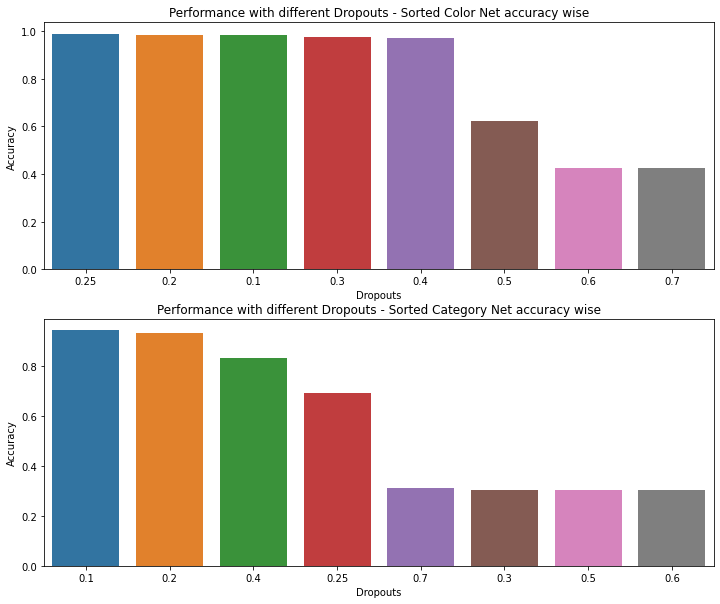

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))
dropout_color_sort = dropout_df.sort_values(by='Color accuracies', ascending=False)
dropout_category_sort = dropout_df.sort_values(by='Category accuracies', ascending=False)

ax[0].set_title('Performance with different Dropouts - Sorted Color Net accuracy wise')
# ax[0].plot(activation_color_sort['Activation'], activation_color_sort['Color accuracies'], marker='d')
sns.barplot(dropout_color_sort['Dropout'], dropout_color_sort['Color accuracies'], ax=ax[0])
ax[0].set_xlabel('Dropouts')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(dropout_color_sort['Dropout'])

ax[1].set_title('Performance with different Dropouts - Sorted Category Net accuracy wise')
# ax[1].plot(activation_category_sort['Activation'], activation_category_sort['Category accuracies'], marker='d')
sns.barplot(dropout_category_sort['Dropout'], dropout_category_sort['Category accuracies'], ax=ax[1])
ax[1].set_xlabel('Dropouts')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticklabels(dropout_category_sort['Dropout'])

plt.show()

## <u>25% dropout value in Color Net and 10% dropout value in Category Net performs the best.</u>

*Color Net Benchmark accuracy : 98.8094*<br>
*Category Net Benchmark accuracy : 94.2210*

<a id='22'></a>
## 4.11 Whether Batch Norm works for us or not ?

Here we will see if adding Batch Norm layer before activation improves model performance for us or not.

In [ ]:
def color_net(inputs):
  x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Dropout(0.25)(x)
  x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(5,5))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(units=32)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Dropout(0.25)(x)
  x = Dense(units=16)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Dropout(0.25)(x)
  x = Dense(units=8)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
  return x

def category_net(inputs):
  x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
  x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Dropout(0.1)(x)
  x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Dropout(0.1)(x)
  x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = MaxPooling2D(pool_size=(3,3))(x)
  x = Dropout(0.1)(x)
  x = Flatten()(x)
  x = Dense(units=32)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(units=16)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(units=8)(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
  return x

def build_model(height, width):
  inputShape = (height, width, 3)
  inputs = Input(shape=inputShape)

  colorClassifier = color_net(inputs)
  categoryClassifier = category_net(inputs)

  model = Model(
      inputs = inputs,
      outputs = [colorClassifier, categoryClassifier]
  )
  return model

In [ ]:
# I will run this test for 5 iterations to make generalized conclusions
model = [0] * 5
history = [0] * 5
for i in range(5):
  model[i] = build_model(IMG_DIMS[0], IMG_DIMS[1])

In [ ]:
# Define loss and optimizer
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

# Define training and testing labels for color and category net
y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train 
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test 
}

# Fitting model
for i in range(5):
  print(f'Training model : {i+1}/5')
  model[i].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[i] = model[i].fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=16,
                            callbacks=[earlyStopping()],
                            validation_data = (X_test, y_test),
                            verbose=2
                          ) 

Epoch 1/500
135/135 - 2s - loss: 2.2819 - color_output_loss: 1.2163 - category_output_loss: 1.0656 - color_output_accuracy: 0.4461 - category_output_accuracy: 0.5613 - val_loss: 1.4269 - val_color_output_loss: 0.7088 - val_category_output_loss: 0.7181 - val_color_output_accuracy: 0.7342 - val_category_output_accuracy: 0.8011
Epoch 2/500
135/135 - 2s - loss: 1.6513 - color_output_loss: 0.8282 - category_output_loss: 0.8231 - color_output_accuracy: 0.6287 - category_output_accuracy: 0.6910 - val_loss: 1.1307 - val_color_output_loss: 0.5935 - val_category_output_loss: 0.5373 - val_color_output_accuracy: 0.7156 - val_category_output_accuracy: 0.8569
Epoch 3/500
135/135 - 2s - loss: 1.4087 - color_output_loss: 0.6740 - category_output_loss: 0.7347 - color_output_accuracy: 0.7165 - category_output_accuracy: 0.7467 - val_loss: 0.8186 - val_color_output_loss: 0.3585 - val_category_output_loss: 0.4601 - val_color_output_accuracy: 0.8885 - val_category_output_accuracy: 0.8810
Epoch 4/500
135/135

In [ ]:
# Computing mean accuracies for each configuration model
mean_val_color_acc = []
mean_val_category_acc = []
for i in range(5):
  val_color_acc = history[i].history['val_color_output_accuracy']
  val_cat_acc = history[i].history['val_category_output_accuracy']
  mean_val_color_acc.append(np.mean(val_color_acc))
  mean_val_category_acc.append(np.mean(val_cat_acc))
print("Color Net accuracy : {:.4f}%".format(np.mean(mean_val_color_acc)*100))
print("Category Net accuracy : {:.4f}%".format(np.mean(mean_val_category_acc)*100))

Color Net accuracy : 95.6645%
Category Net accuracy : 91.0035%


## We can see that <u>adding Batch Normalization layer decreases our model perfomance</u> - ~3% for Color Net and ~3% for Category Net. Hence we won't include thi sin our final model architecture. 

<a id='23'></a>
# 5. Final Model

In [ ]:
class FinalModel:
  def color_net(inputs):
    x = Conv2D(filters=8, kernel_size=(3,3), padding='same')(inputs)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(5,5))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(5,5))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(units=32)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.25)(x)
    x = Dense(units=16)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.25)(x)
    x = Dense(units=8)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_COLORS, activation='softmax', name='color_output')(x)
    return x

  def category_net(inputs):
    x = Lambda(lambda x : tf.image.rgb_to_grayscale(x))(inputs)
    x = Conv2D(filters=8, kernel_size=(5,5), padding='same')(x)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(3,3))(x)
    x = Dropout(0.1)(x)
    x = Conv2D(filters=16, kernel_size=(5,5), padding='same')(x)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(3,3))(x)
    x = Dropout(0.1)(x)
    x = Conv2D(filters=24, kernel_size=(5,5), padding='same')(x)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(3,3))(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(units=32)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=16)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=8)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CATEGORIES, activation='softmax', name='category_output')(x)
    return x

  def build_model(height, width):
    inputShape = (height, width, 3)
    inputs = Input(shape=inputShape)

    colorClassifier = FinalModel.color_net(inputs)
    categoryClassifier = FinalModel.category_net(inputs)

    model = Model(
        inputs = inputs,
        outputs = [colorClassifier, categoryClassifier]
    )
    return model

In [ ]:
# We will use KFOLD cross validation to validate our model
NFOLDS = 5
kf = KFold(n_splits=5, random_state=42)

In [ ]:
loss = {
    'color_output' : 'categorical_crossentropy',
    'category_output' : 'categorical_crossentropy'
}

optimizer = tf.keras.optimizers.Adam()

y_train = {
    'color_output' : y_color_train,
    'category_output' : y_category_train
}

y_test = {
    'color_output' : y_color_test,
    'category_output' : y_category_test
}

# Define model and history list for each fold
model = [0] * NFOLDS
history = [0] * NFOLDS

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
  print("\nFold : {}\n".format(fold+1))
  
  X_tr, y_tr_color, y_tr_categroy = X_train[tr_idx], y_train['color_output'][tr_idx], y_train['category_output'][tr_idx]
  X_val, y_val_color, y_val_category = X_train[val_idx], y_train['color_output'][val_idx], y_train['category_output'][val_idx]
  
  # Fold train labels
  y_tr = {
      'color_output' : y_tr_color,
      'category_output' : y_tr_categroy
  }
  # Fold validation labels
  y_val = {
      'color_output' : y_val_color,
      'category_output' : y_val_category
  }

  model[fold] = FinalModel.build_model(IMG_DIMS[0], IMG_DIMS[1])
  model[fold].compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  history[fold] = model[fold].fit(X_tr, y_tr,
                                  epochs=EPOCHS,
                                  batch_size=16,
                                  callbacks=[earlyStopping()],
                                  validation_data = (X_val, y_val), 
                                  verbose=1 
                                )


Fold : 1

Epoch 1/500
108/108 [==============================] - 1s 13ms/step - loss: 2.0138 - color_output_loss: 0.9319 - category_output_loss: 1.0819 - color_output_accuracy: 0.5288 - category_output_accuracy: 0.5270 - val_loss: 1.1402 - val_color_output_loss: 0.4664 - val_category_output_loss: 0.6738 - val_color_output_accuracy: 0.8121 - val_category_output_accuracy: 0.8097
Epoch 2/500
108/108 [==============================] - 1s 10ms/step - loss: 1.2254 - color_output_loss: 0.5062 - category_output_loss: 0.7192 - color_output_accuracy: 0.7850 - category_output_accuracy: 0.7461 - val_loss: 0.7692 - val_color_output_loss: 0.3039 - val_category_output_loss: 0.4653 - val_color_output_accuracy: 0.9443 - val_category_output_accuracy: 0.8886
Epoch 3/500
108/108 [==============================] - 1s 10ms/step - loss: 0.9378 - color_output_loss: 0.3810 - category_output_loss: 0.5567 - color_output_accuracy: 0.8658 - category_output_accuracy: 0.8239 - val_loss: 0.5417 - val_color_output_lo

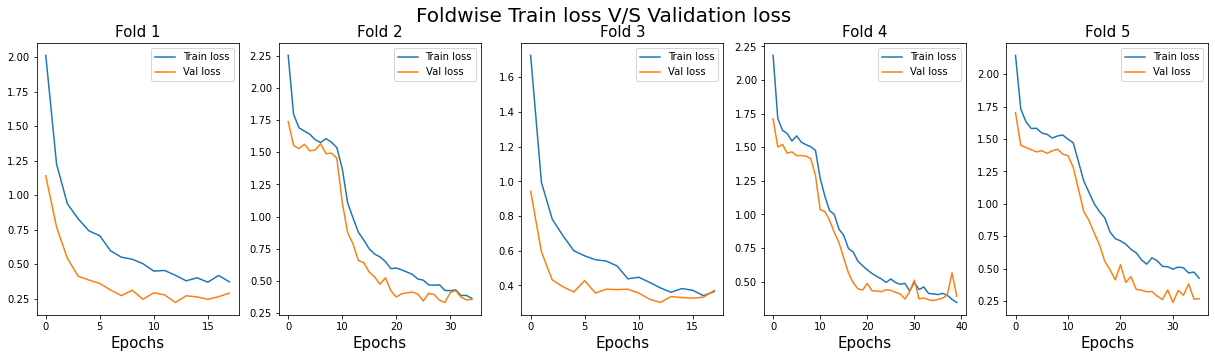

In [ ]:
# Plotting train loss V/S validation loss
folds_list = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
loss = ['Train loss', 'Val loss']
fig, ax = plt.subplots(1, 5, figsize=(21, 5))
plt.suptitle('Foldwise Train loss V/S Validation loss', fontsize=20)
for i in range(NFOLDS):
  ax[i].plot(history[i].history['loss'])
  ax[i].plot(history[i].history['val_loss'])
  ax[i].set_title(folds_list[i], fontsize=15)
  ax[i].set_xlabel("Epochs", fontsize=15)
  ax[i].legend(loss, loc='best')
plt.show(fig)

In [ ]:
# Getting overall accuracy (i.e mean of color and category accuracy) for each fold
mean_overall_accuracy = []
for i in range(NFOLDS):
  fold_val_color_acc = np.mean(history[i].history['val_color_output_accuracy'])
  fold_val_coategory_acc = np.mean(history[i].history['val_category_output_accuracy'])
  mean_overall_accuracy.append(np.mean([fold_val_color_acc, fold_val_coategory_acc]))

# Extract the fold model with highest overall accuracy
max_acc_idx = np.argmax(mean_overall_accuracy)
best_model = model[max_acc_idx]

In [ ]:
# Foldwise model accuracy
foldwise_acc_df = pd.DataFrame({'Fold' : folds_list,
                                'Overall accuracy(%)' : [x*100 for x in mean_overall_accuracy]
                              })
foldwise_acc_df

,Fold,Overall accuracy(%)
0,Fold 1,94.721577
1,Fold 2,83.592973
2,Fold 3,93.888889
3,Fold 4,84.697674
4,Fold 5,82.868217


<a id='24'></a>
# 6. Save Model and Label Binarizer

In [ ]:
save_path = '/content/drive/My Drive/Fashion MNIST Project/'

# Save model
best_model.save(save_path + 'BestCustomModel')

# Save color labelBinarizer 
f = open(save_path + 'labelBinarizer_color.pkl', 'wb')
f.write(pickle.dumps(lb_color))
f.close()

# Save category labelBinarizer 
f = open(save_path + 'labelBinarizer_category.pkl', 'wb')
f.write(pickle.dumps(lb_category))
f.close()

INFO:tensorflow:Assets written to: /content/drive/My Drive/Fashion MNIST Project/BestCustomModel/assets


<a id='25'></a>
# 7. Classification on User data

Here, I will detect color and category on an image which is never seen before by the model.

In [ ]:
import cv2
import pickle
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
IMG_DIMS = (96,96,3)
NUM_COLORS = 3
NUM_CATEGORIES = 4

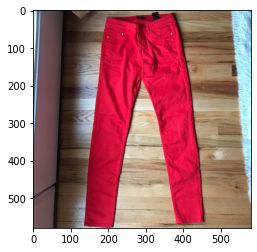

In [ ]:
# Load image and display
img_path = '/content/drive/My Drive/Fashion MNIST Project/examples/asd_Asd.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# MAKE PREDICTION

# get model and label binarizer paths
lb_path = '/content/drive/My Drive/Fashion MNIST Project/'
model_path = '/content/drive/My Drive/Fashion MNIST Project/BestCustomModel'

# Read the user image, resize it, normalize the pixel values and covert to numpy array
X_user = [] 
actual_values = []
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_DIMS[1], IMG_DIMS[0]))
img = img / 255.0
X_user.append(img)
color_category = img_path.split('/')[-1].split('_')
(color, category) = color_category[0:2]
actual_values.append((color, category))
X_user = np.array(X_user)

# Laod model
model = load_model(model_path)
# Predict 
(color, category) = model.predict(X_user)

# get max prob indices and max prob values
color_idx = np.argmax(color)
cat_idx = np.argmax(category)
color_prob = color[0][color_idx]
cat_prob = category[0][cat_idx]

# Load color and category labelBinarizers
f_col = open(lb_path + 'labelBinarizer_color.pkl', 'rb')
f_cat = open(lb_path + 'labelBinarizer_category.pkl', 'rb')
lb_color = pickle.loads(f_col.read())
lb_category = pickle.loads(f_cat.read())
f_col.close()
f_cat.close()
# inverse trasform colors and category to get label values
cat_arr = np.zeros((1, NUM_CATEGORIES))
color_arr = np.zeros((1, NUM_COLORS))
cat_arr[0][cat_idx] = 1
color_arr[0][color_idx] = 1
cat = lb_category.inverse_transform(cat_arr)
col = lb_color.inverse_transform(color_arr)

In [ ]:
print("Model Prediction => Color : {} ({:.2f}), Category : {} ({:.2f})".format(col[0], color_prob*100, cat[0], cat_prob*100))

Model Prediction => Color : red (98.94), Category : jeans (99.12)
